<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/baseline_models/CNN/FeatureKernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import time

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/APS360 Project/kaggle_dataset/separate_dataset.zip' -d {os.path.expanduser('~/data')}

# Transfer Learning with AlexNet

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data/separate_dataset'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)


In [ ]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data/separate_dataset'))
classes.sort()
classes = classes[1:]
print(classes)

{'14719': 0, '15672': 1, '18654': 2, '2357': 3, '2420': 4, '2780': 5, '27925': 6, '3001': 7, '3002': 8, '3003': 9, '3004': 10, '3005': 11, '3010': 12, '3020': 13, '3021': 14, '3022': 15, '3023': 16, '3024': 17, '3037': 18, '3038': 19, '3039': 20, '3040': 21, '3045': 22, '3046': 23, '3062': 24, '3063': 25, '3068': 26, '3069': 27, '3070': 28, '3298': 29, '33909': 30, '3622': 31, '3623': 32, '3659': 33, '3675': 34, '3700': 35, '3794': 36, '4150': 37, '41677': 38, '41678': 39, '4274': 40, '4286': 41, '43093': 42, '43857': 43, '4490': 44, '54200': 45, '6143': 46, '6632': 47, '85984': 48, '99301': 49}
['14719', '15672', '18654', '2357', '2420', '2780', '27925', '3001', '3002', '3003', '3004', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3037', '3038', '3039', '3040', '3045', '3046', '3062', '3063', '3068', '3069', '3070', '3298', '33909', '3622', '3623', '3659', '3675', '3700', '3794', '4150', '41677', '41678', '4274', '4286', '43093', '43857', '4490', '54200', '6143', '6632', '8

In [ ]:
feature_root_path = os.path.expanduser('~/feature')
for i in classes:
  path = os.path.join(feature_root_path, i)
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
# generate and save feature maps
i = 0
for img, label in loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  features_folder_path = os.path.join(feature_root_path, classes[label])
  feature_path = os.path.join(features_folder_path, "{}.tensor".format(i))
  torch.save(features_tensor.squeeze(0), feature_path)
  i += 1
  print("saved {} images".format(i))

In [ ]:
!zip feature.zip -r {feature_root_path}

In [ ]:
!unzip '/content/drive/My Drive/APS360 Project/kaggle_dataset/feature.zip' -d {os.path.expanduser('~/')}
feature_root_path = os.path.expanduser('~/root/feature/')

In [ ]:
# function to load features
def feature_loader(feature_root_path, train_p, val_p, batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(feature_root_path,\
                                                 loader = torch.load, extensions = ('.tensor'))

  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

In [ ]:
train_data, val_data, test_data = feature_loader(feature_root_path, 0.6, 0.2, 32)

In [ ]:
class TransferLearningNet(nn.Module):
  def __init__(self):
    super(TransferLearningNet, self).__init__()
    self.name = "tNet"
    self.fc1 = nn.Linear(256*6*6, 120)
    self.fc2 = nn.Linear(120, 50)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    return x

tNet = TransferLearningNet()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]       1,106,040
            Linear-2                   [-1, 50]           6,050
Total params: 1,112,090
Trainable params: 1,112,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.00
Params size (MB): 4.24
Estimated Total Size (MB): 4.28
----------------------------------------------------------------


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  total_loss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      imgs, labels = data
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      output = model(imgs)

      # select index with maximum prediction score
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
      total_loss += criterion(output, labels).item()
  return 1 - correct/total, total_loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
  containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def transfer_train(model, batch_size = 32, num_epochs = 10, lr = 0.003, wd = 1e-5):
  torch.manual_seed(360)

  train_loader, val_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size)

  # Initialize containers for error and loss
  train_err, train_loss, val_err, val_loss = [], [], [], []

  # set up optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr, 
                                 weight_decay=wd)

  start_time = time.time()

  for epoch in range(num_epochs):
    epoch_total = 0
    epoch_correct = 0
    epoch_loss = 0
    model.train()
    for feature, labels in iter(train_loader):

      # Enable GPU
      if use_cuda and torch.cuda.is_available():
        feature = feature.cuda()
        labels = labels.cuda()
      
      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass, backward pass, and optimize
      out = model(feature)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      
      # mini batch statistics
      pred = out.max(1, keepdim = True)[1]
      epoch_correct += pred.eq(labels.view_as(pred)).sum().item()
      epoch_total += feature.shape[0]
      epoch_loss += loss.item()
    train_err.append(1 - (epoch_correct / epoch_total))
    train_loss.append(epoch_loss)
    a, b = evaluate(model, val_loader, criterion)
    val_err.append(a)
    val_loss.append(b)
    
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    print ("train err: {:.4f}, train loss: {:.4f}".format(train_err[epoch], train_loss[epoch]))
    print ("validation err: {:.4f}, validation loss: {:.4f}".format(a, b))

    # save the current model state
    model_path = get_model_name(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
  
  print('Finished training in %6.2f s' % (time.time()-start_time))
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# training with the initial set up
use_cuda = False
tNet = TransferLearningNet()
transfer_train(tNet, batch_size=32, num_epochs=30, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:  14.32 s 
train err: 0.5113, train loss: 1268.8486
validation err: 0.3528, validation loss: 271.5240
Epoch 1 Finished.  Time per Epoch:  14.24 s 
train err: 0.2958, train loss: 670.3000
validation err: 0.2924, validation loss: 215.6308
Epoch 2 Finished.  Time per Epoch:  14.25 s 
train err: 0.2260, train loss: 509.0903
validation err: 0.2660, validation loss: 194.7553
Epoch 3 Finished.  Time per Epoch:  14.27 s 
train err: 0.1882, train loss: 418.3469
validation err: 0.2485, validation loss: 176.1109
Epoch 4 Finished.  Time per Epoch:  14.25 s 
train err: 0.1585, train loss: 350.3568
validation err: 0.2504, validation loss: 179.2194
Epoch 5 Finished.  Time per Epoch:  14.23 s 
train err: 0.1362, train loss: 304.8135
validation err: 0.2255, validation loss: 163.2128
Epoch 6 Finished.  Time per Epoch:  14.17 s 
train err: 0.1197, train loss: 266.5183
validation err: 0.2254, validation loss: 165.3238
Epoch 7 Finished.  Time per Epoch:  14.14 s 
train err

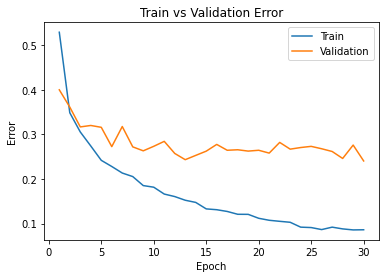

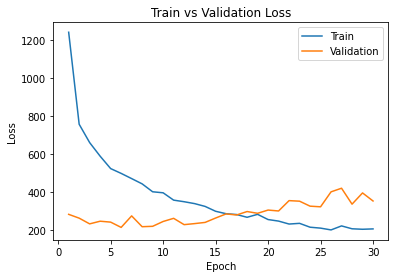

In [ ]:
plot_training_curve(get_model_name(tNet.name, 32, 0.003, 29))

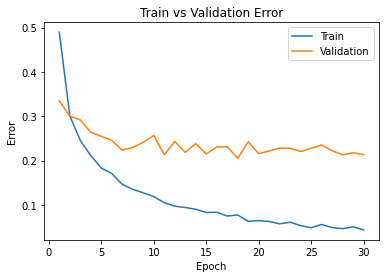

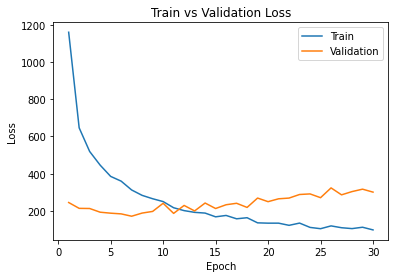

In [ ]:
plot_training_curve(get_model_name(tNet.name, 32, 0.0015, 29))

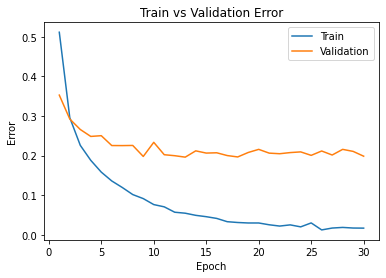

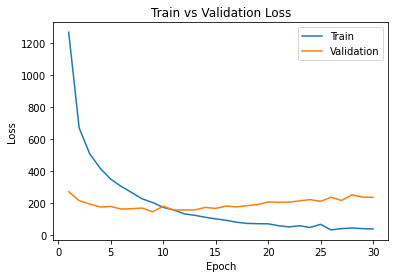

In [ ]:
plot_training_curve(get_model_name(tNet.name, 32, 0.0005, 29))

In [ ]:
#Training with larger batch size
use_cuda = False
tNet = TransferLearningNet()
transfer_train(tNet, batch_size=500, num_epochs=30, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:   6.97 s 
train err: 0.6981, train loss: 127.5145
validation err: 0.5074, validation loss: 30.0698
Epoch 1 Finished.  Time per Epoch:   6.90 s 
train err: 0.4243, train loss: 74.5772
validation err: 0.3974, validation loss: 22.1473
Epoch 2 Finished.  Time per Epoch:   6.85 s 
train err: 0.3295, train loss: 56.5384
validation err: 0.3496, validation loss: 18.5046
Epoch 3 Finished.  Time per Epoch:   6.83 s 
train err: 0.2794, train loss: 47.0117
validation err: 0.3113, validation loss: 16.5340
Epoch 4 Finished.  Time per Epoch:   6.80 s 
train err: 0.2417, train loss: 40.7041
validation err: 0.2802, validation loss: 14.6734
Epoch 5 Finished.  Time per Epoch:   6.80 s 
train err: 0.2090, train loss: 35.4935
validation err: 0.2635, validation loss: 13.5977
Epoch 6 Finished.  Time per Epoch:   6.79 s 
train err: 0.1885, train loss: 32.1623
validation err: 0.2572, validation loss: 12.9822
Epoch 7 Finished.  Time per Epoch:   6.78 s 
train err: 0.1725, trai

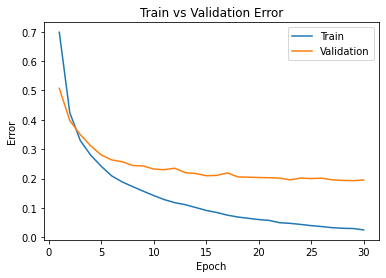

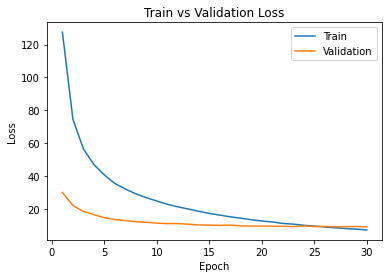

In [ ]:
plot_training_curve(get_model_name(tNet.name, 500, 0.0005, 29))

#AlexNet with Drop out

In [ ]:
class TransferLearningNetDp(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp, self).__init__()
    self.name = "tNetDp"
    self.fc1 = nn.Linear(256*6*6, 120)
    self.fc2 = nn.Linear(120, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]       1,106,040
            Linear-2                   [-1, 50]           6,050
           Dropout-3                   [-1, 50]               0
Total params: 1,112,090
Trainable params: 1,112,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.00
Params size (MB): 4.24
Estimated Total Size (MB): 4.28
----------------------------------------------------------------


In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.3)
transfer_train(tNetDp, batch_size=500, num_epochs=100, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:   7.30 s 
train err: 0.7694, train loss: 149.3372
validation err: 0.5361, validation loss: 35.9651
Epoch 1 Finished.  Time per Epoch:   7.18 s 
train err: 0.5777, train loss: 112.7886
validation err: 0.4411, validation loss: 27.7139
Epoch 2 Finished.  Time per Epoch:   7.14 s 
train err: 0.5065, train loss: 97.7604
validation err: 0.3454, validation loss: 23.0656
Epoch 3 Finished.  Time per Epoch:   7.12 s 
train err: 0.4696, train loss: 89.9214
validation err: 0.3273, validation loss: 20.5258
Epoch 4 Finished.  Time per Epoch:   7.11 s 
train err: 0.4555, train loss: 85.2046
validation err: 0.3006, validation loss: 18.7585
Epoch 5 Finished.  Time per Epoch:   7.10 s 
train err: 0.4340, train loss: 81.3541
validation err: 0.2835, validation loss: 17.4010
Epoch 6 Finished.  Time per Epoch:   7.08 s 
train err: 0.4226, train loss: 78.1373
validation err: 0.2711, validation loss: 16.2628
Epoch 7 Finished.  Time per Epoch:   7.07 s 
train err: 0.4126, tra

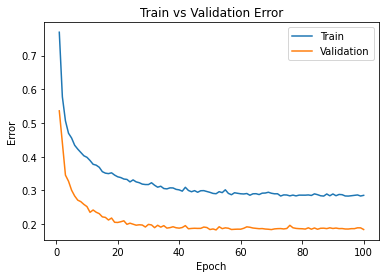

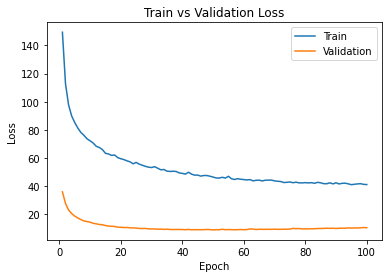

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.0005, 99))

In [ ]:
class TransferLearningNetDp(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp, self).__init__()
    self.name = "tNetDp2"
    self.fc1 = nn.Linear(256*6*6, 1200)
    self.fc2 = nn.Linear(1200, 120)
    self.fc3 = nn.Linear(120, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1200]      11,060,400
            Linear-2                  [-1, 120]         144,120
            Linear-3                   [-1, 50]           6,050
           Dropout-4                   [-1, 50]               0
Total params: 11,210,570
Trainable params: 11,210,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.01
Params size (MB): 42.76
Estimated Total Size (MB): 42.81
----------------------------------------------------------------


In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.3)
transfer_train(tNetDp, batch_size=500, num_epochs=100, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:  27.95 s 
train err: 0.7533, train loss: 143.0990
validation err: 0.5068, validation loss: 30.8381
Epoch 1 Finished.  Time per Epoch:  27.61 s 
train err: 0.5565, train loss: 103.1281
validation err: 0.3918, validation loss: 22.3816
Epoch 2 Finished.  Time per Epoch:  27.48 s 
train err: 0.4872, train loss: 89.0134
validation err: 0.3438, validation loss: 19.1133
Epoch 3 Finished.  Time per Epoch:  27.38 s 
train err: 0.4520, train loss: 81.9348
validation err: 0.3167, validation loss: 16.9320
Epoch 4 Finished.  Time per Epoch:  27.36 s 
train err: 0.4329, train loss: 77.3797
validation err: 0.2880, validation loss: 15.1525
Epoch 5 Finished.  Time per Epoch:  27.34 s 
train err: 0.4125, train loss: 73.2565
validation err: 0.2514, validation loss: 13.5040
Epoch 6 Finished.  Time per Epoch:  27.32 s 
train err: 0.3959, train loss: 69.9235
validation err: 0.2509, validation loss: 12.8776
Epoch 7 Finished.  Time per Epoch:  27.30 s 
train err: 0.3902, tra

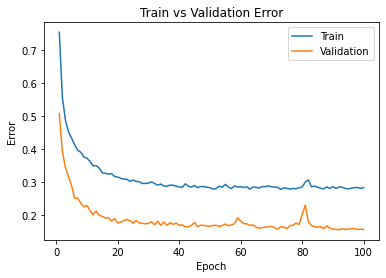

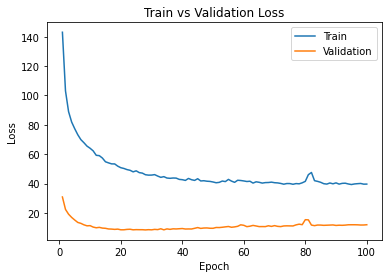

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.0005, 99))

In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.3)
transfer_train(tNetDp, batch_size=100, num_epochs=100, lr=0.0005)

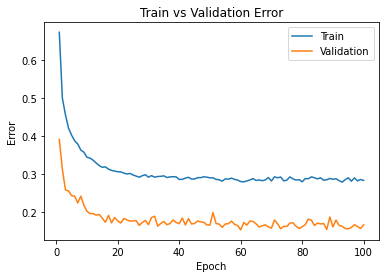

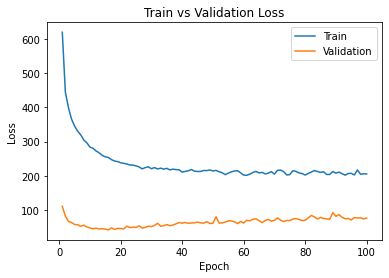

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 100, 0.0005, 99))

In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.3)
transfer_train(tNetDp, batch_size=100, num_epochs=100, lr=0.005)

Epoch 0 Finished.  Time per Epoch:   9.78 s 
train err: 0.6924, train loss: 652.3735
validation err: 0.4964, validation loss: 125.3632
Epoch 1 Finished.  Time per Epoch:   9.60 s 
train err: 0.5596, train loss: 503.9649
validation err: 0.3914, validation loss: 95.5635
Epoch 2 Finished.  Time per Epoch:   9.58 s 
train err: 0.5224, train loss: 471.4039
validation err: 0.3709, validation loss: 91.6938
Epoch 3 Finished.  Time per Epoch:   9.55 s 
train err: 0.4936, train loss: 442.8052
validation err: 0.3568, validation loss: 85.6339
Epoch 4 Finished.  Time per Epoch:   9.54 s 
train err: 0.4772, train loss: 430.8696
validation err: 0.3434, validation loss: 83.2301
Epoch 5 Finished.  Time per Epoch:   9.78 s 
train err: 0.4678, train loss: 421.6030
validation err: 0.3177, validation loss: 76.0355
Epoch 6 Finished.  Time per Epoch:   9.94 s 
train err: 0.4509, train loss: 407.3308
validation err: 0.3149, validation loss: 76.6956
Epoch 7 Finished.  Time per Epoch:  10.07 s 
train err: 0.445

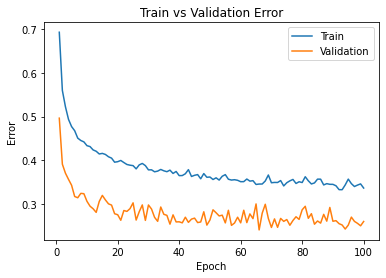

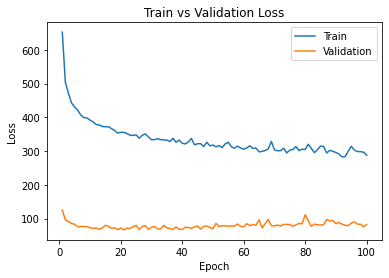

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 100, 0.005, 99))

In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.5)
transfer_train(tNetDp, batch_size=500, num_epochs=100, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:   7.39 s 
train err: 0.8260, train loss: 162.6400
validation err: 0.6138, validation loss: 41.6824
Epoch 1 Finished.  Time per Epoch:   7.27 s 
train err: 0.6816, train loss: 134.7900
validation err: 0.4397, validation loss: 32.9327
Epoch 2 Finished.  Time per Epoch:   7.25 s 
train err: 0.6316, train loss: 123.6458
validation err: 0.3721, validation loss: 28.5823
Epoch 3 Finished.  Time per Epoch:   7.24 s 
train err: 0.6052, train loss: 117.8987
validation err: 0.3549, validation loss: 25.6902
Epoch 4 Finished.  Time per Epoch:   7.22 s 
train err: 0.5996, train loss: 115.2805
validation err: 0.3166, validation loss: 23.8588
Epoch 5 Finished.  Time per Epoch:   7.22 s 
train err: 0.5863, train loss: 111.7432
validation err: 0.3069, validation loss: 22.2931
Epoch 6 Finished.  Time per Epoch:   7.20 s 
train err: 0.5740, train loss: 108.9933
validation err: 0.2815, validation loss: 21.0335
Epoch 7 Finished.  Time per Epoch:   7.19 s 
train err: 0.5689

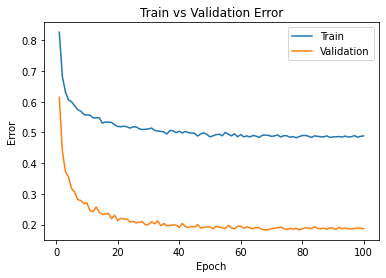

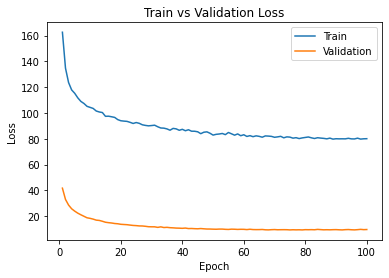

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.0005, 99))

In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.5)
transfer_train(tNetDp, batch_size=300, num_epochs=100, lr=0.001)

Epoch 0 Finished.  Time per Epoch:   8.90 s 
train err: 0.7981, train loss: 259.2746
validation err: 0.5019, validation loss: 58.7173
Epoch 1 Finished.  Time per Epoch:   8.28 s 
train err: 0.6573, train loss: 212.1966
validation err: 0.4123, validation loss: 45.8502
Epoch 2 Finished.  Time per Epoch:   8.04 s 
train err: 0.6156, train loss: 197.2020
validation err: 0.3546, validation loss: 39.5964
Epoch 3 Finished.  Time per Epoch:   7.93 s 
train err: 0.6018, train loss: 190.0932
validation err: 0.3190, validation loss: 35.3106
Epoch 4 Finished.  Time per Epoch:   7.89 s 
train err: 0.5808, train loss: 182.4988
validation err: 0.3013, validation loss: 32.6456
Epoch 5 Finished.  Time per Epoch:   7.84 s 
train err: 0.5776, train loss: 179.8732
validation err: 0.2850, validation loss: 30.8629
Epoch 6 Finished.  Time per Epoch:   7.81 s 
train err: 0.5682, train loss: 175.9399
validation err: 0.2664, validation loss: 28.3067
Epoch 7 Finished.  Time per Epoch:   7.78 s 
train err: 0.5631

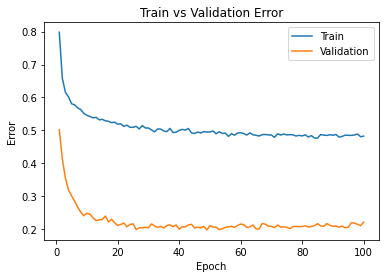

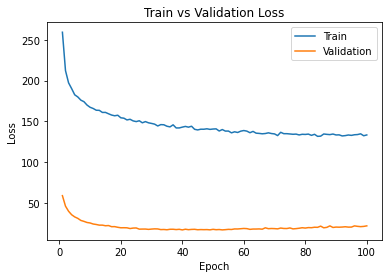

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 300, 0.001, 99))

In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp(0.5)
transfer_train(tNetDp, batch_size=50, num_epochs=100, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  13.43 s 
train err: 0.7573, train loss: 1448.0415
validation err: 0.4696, validation loss: 286.1356
Epoch 1 Finished.  Time per Epoch:  13.17 s 
train err: 0.6305, train loss: 1206.2808
validation err: 0.3725, validation loss: 225.2701
Epoch 2 Finished.  Time per Epoch:  13.76 s 
train err: 0.6112, train loss: 1156.7881
validation err: 0.3114, validation loss: 189.0847
Epoch 3 Finished.  Time per Epoch:  14.24 s 
train err: 0.5932, train loss: 1119.9823
validation err: 0.2956, validation loss: 176.2384
Epoch 4 Finished.  Time per Epoch:  14.46 s 
train err: 0.5808, train loss: 1089.9151
validation err: 0.2836, validation loss: 162.4051
Epoch 5 Finished.  Time per Epoch:  14.63 s 
train err: 0.5761, train loss: 1069.2269
validation err: 0.2947, validation loss: 165.3362
Epoch 6 Finished.  Time per Epoch:  14.75 s 
train err: 0.5753, train loss: 1062.4671
validation err: 0.2605, validation loss: 148.8499
Epoch 7 Finished.  Time per Epoch:  14.84 s 
tra

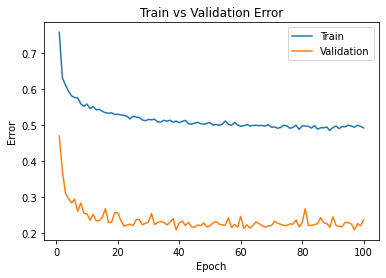

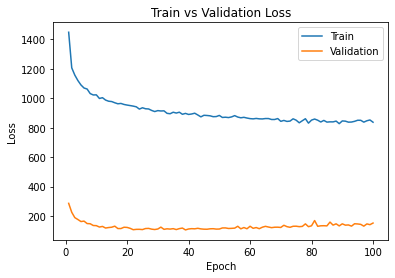

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 50, 0.001, 99))

In [ ]:
class TransferLearningNetDp3(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp3, self).__init__()
    self.name = "tNetDp3"
    self.fc1 = nn.Linear(256*6*6, 3600)
    self.fc2 = nn.Linear(3600, 1200)
    self.fc3 = nn.Linear(1200, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp3()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3600]      33,181,200
            Linear-2                 [-1, 1200]       4,321,200
            Linear-3                   [-1, 50]          60,050
           Dropout-4                   [-1, 50]               0
Total params: 37,562,450
Trainable params: 37,562,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.04
Params size (MB): 143.29
Estimated Total Size (MB): 143.36
----------------------------------------------------------------


In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp3(0.3)
transfer_train(tNetDp, batch_size=500, num_epochs=100, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  81.39 s 
train err: 0.7376, train loss: 139.0317
validation err: 0.4397, validation loss: 23.8358
Epoch 1 Finished.  Time per Epoch:  81.82 s 
train err: 0.5095, train loss: 90.0567
validation err: 0.3317, validation loss: 16.4320
Epoch 2 Finished.  Time per Epoch:  81.87 s 
train err: 0.4437, train loss: 76.8811
validation err: 0.2808, validation loss: 13.3770
Epoch 3 Finished.  Time per Epoch:  81.88 s 
train err: 0.4133, train loss: 70.4986
validation err: 0.2374, validation loss: 11.1935
Epoch 4 Finished.  Time per Epoch:  81.89 s 
train err: 0.3901, train loss: 65.9398
validation err: 0.2164, validation loss: 10.4087
Epoch 5 Finished.  Time per Epoch:  81.90 s 
train err: 0.3798, train loss: 63.5310
validation err: 0.2149, validation loss: 10.0044
Epoch 6 Finished.  Time per Epoch:  82.08 s 
train err: 0.3678, train loss: 60.6273
validation err: 0.1956, validation loss: 9.1946
Epoch 7 Finished.  Time per Epoch:  82.09 s 
train err: 0.3567, train

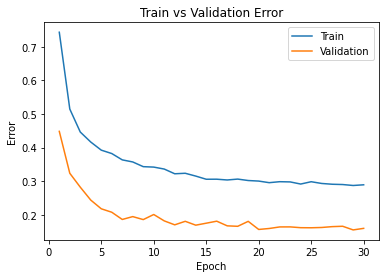

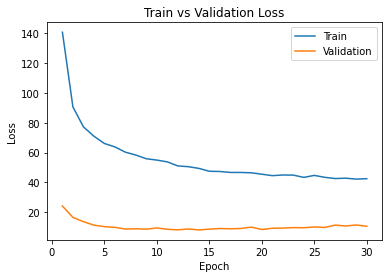

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.001, 29))

# Known Kernels

In [ ]:
weights = torch.tensor([[[3., 10., 3.],
                        [0., 0., 0.],
                        [-3., -10., -3.]],
                        [[-3., -10., -3.],
                        [0., 1., 0.],
                        [3., 10., 3.]],
                        [[-3., 0., 3.],
                        [-10., 0., 10.],
                        [-3., 0., 3.]],
                        [[3., 0., -3.],
                        [10., 0., -10.],
                        [3., 0., -3.]],
                        [[-2., -1., 0.],
                        [-1., 1., 1.],
                        [0., 1., 2.]],
                        ])
weights = weights.view(5, 1, 3, 3).repeat(1, 1, 1, 1)
weights

tensor([[[[  3.,  10.,   3.],
          [  0.,   0.,   0.],
          [ -3., -10.,  -3.]]],


        [[[ -3., -10.,  -3.],
          [  0.,   1.,   0.],
          [  3.,  10.,   3.]]],


        [[[ -3.,   0.,   3.],
          [-10.,   0.,  10.],
          [ -3.,   0.,   3.]]],


        [[[  3.,   0.,  -3.],
          [ 10.,   0., -10.],
          [  3.,   0.,  -3.]]],


        [[[ -2.,  -1.,   0.],
          [ -1.,   1.,   1.],
          [  0.,   1.,   2.]]]])

In [ ]:

class ImageFilterCNN(nn.Module):
  def __init__(self):
    super(ImageFilterCNN, self).__init__()
    self.name = "FilterNet"
    self.conv1 = nn.Conv2d(5, 8, 5) #in_channels, out_channels, kernel_size
    self.conv2 = nn.Conv2d(8, 10, 5) #in_channels, out_channels, kernel_size
    self.conv3 = nn.Conv2d(10, 16, 3, 2) #in_channels, out_channels, kernel_size, stride
    self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 

    self.fc1 = nn.Linear(2304, 120)
    self.fc2 = nn.Linear(120, 50)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 2304)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

tNet = ImageFilterCNN()
# summary(tNet, (1,224,224), device='cpu')

In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 32

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data/separate_dataset'), transform=data_transform)


In [ ]:
# function to load features
def image_loader(dataset, train_p, val_p, batch_size = 32):
  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

In [ ]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data/separate_dataset'))
classes.sort()
classes = classes[1:]
print(classes)

{'14719': 0, '15672': 1, '18654': 2, '2357': 3, '2420': 4, '2780': 5, '27925': 6, '3001': 7, '3002': 8, '3003': 9, '3004': 10, '3005': 11, '3010': 12, '3020': 13, '3021': 14, '3022': 15, '3023': 16, '3024': 17, '3037': 18, '3038': 19, '3039': 20, '3040': 21, '3045': 22, '3046': 23, '3062': 24, '3063': 25, '3068': 26, '3069': 27, '3070': 28, '3298': 29, '33909': 30, '3622': 31, '3623': 32, '3659': 33, '3675': 34, '3700': 35, '3794': 36, '4150': 37, '41677': 38, '41678': 39, '4274': 40, '4286': 41, '43093': 42, '43857': 43, '4490': 44, '54200': 45, '6143': 46, '6632': 47, '85984': 48, '99301': 49}
['14719', '15672', '18654', '2357', '2420', '2780', '27925', '3001', '3002', '3003', '3004', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3037', '3038', '3039', '3040', '3045', '3046', '3062', '3063', '3068', '3069', '3070', '3298', '33909', '3622', '3623', '3659', '3675', '3700', '3794', '4150', '41677', '41678', '4274', '4286', '43093', '43857', '4490', '54200', '6143', '6632', '8

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  total_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      imgs, labels = data
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      weight = weights.view(5,1,3,3).repeat(batch_size, 1, 1, 1)
      imgs = F.conv2d(imgs, weights) 
      output = model(imgs)

      # select index with maximum prediction score
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
      total_loss += criterion(output, labels).item()
  return 1 - correct/total, total_loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
  containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def filter_train(model, batch_size = 32, num_epochs = 10, lr = 0.003):
  torch.manual_seed(360)
  train_loader, val_loader, test_loader = image_loader(image_set, 0.6, 0.2, batch_size)

  # Initialize containers for error and loss
  train_err, train_loss, val_err, val_loss = [], [], [], []

  # set up optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr)

  start_time = time.time()

  for epoch in range(num_epochs):
    epoch_total = 0
    epoch_correct = 0
    epoch_loss = 0

    for data, labels in iter(train_loader):

      # Enable GPU
      if use_cuda and torch.cuda.is_available():
        data = data.cuda()
        labels = labels.cuda()
      
      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass, backward pass, and optimize
      weight = weights.view(1,5,3,3).repeat(batch_size, 1, 1, 1)
      data = F.conv2d(data, weights)
      out = model(data)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      
      # mini batch statistics
      pred = out.max(1, keepdim = True)[1]
      epoch_correct += pred.eq(labels.view_as(pred)).sum().item()
      epoch_total += data.shape[0]
      epoch_loss += loss.item()
    train_err.append(1 - (epoch_correct / epoch_total))
    train_loss.append(epoch_loss)
    a, b = evaluate(model, val_loader, criterion)
    val_err.append(a)
    val_loss.append(b)
    
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    print ("train err: {:.4f}, train loss: {:.4f}".format(train_err[epoch], train_loss[epoch]))
    print ("validation err: {:.4f}, validation loss: {:.4f}".format(a, b))

    # save the current model state
    model_path = get_model_name(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
  
  print('Finished training in %6.2f s' % (time.time()-start_time))
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
# training with the initial set up
use_cuda = False
fNet1 = ImageFilterCNN()
filter_train(fNet1, batch_size=32, num_epochs=30, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:  594.95 s 
train err: 0.7152, train loss: 1755.1611
validation err: 0.6139, validation loss: 483.3541
Epoch 1 Finished.  Time per Epoch:  593.91 s 
train err: 0.5256, train loss: 1229.7636
validation err: 0.5232, validation loss: 403.3026
Epoch 2 Finished.  Time per Epoch:  593.75 s 
train err: 0.4197, train loss: 961.4780
validation err: 0.4553, validation loss: 349.9777
Epoch 3 Finished.  Time per Epoch:  594.01 s 
train err: 0.3409, train loss: 773.2966
validation err: 0.4340, validation loss: 339.0386
Epoch 4 Finished.  Time per Epoch:  593.77 s 
train err: 0.2841, train loss: 635.7643
validation err: 0.4224, validation loss: 337.6139
Epoch 5 Finished.  Time per Epoch:  593.86 s 
train err: 0.2361, train loss: 526.4711
validation err: 0.4010, validation loss: 321.6245
Epoch 6 Finished.  Time per Epoch:  593.89 s 
train err: 0.2003, train loss: 439.6393
validation err: 0.3872, validation loss: 336.0486
Epoch 7 Finished.  Time per Epoch:  594.21 s 
